In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K

from MD_AE_model import *
import myplot
import mode_decomposition as md

import h5py
import numpy as np
import matplotlib.pyplot as plt

2022-04-26 14:28:04.343260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 14:28:04.343289: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
## import data
folder = '/home/ym917/OneDrive/PhD/Code_md-ae/Hierarchical_10_1__2022_04_12__15_54_24/'
filename = folder + 'results.h5'
hf = h5py.File(filename,'r')
u_test = np.array(hf.get('u_test'))
hist_train = np.array(hf.get('hist_train'))
hist_val = np.array(hf.get('hist_val'))
u_avg = np.array(hf.get('u_avg'))
latent_test = np.array(hf.get('latent_test')) # shape [latent_variable, test_snapshots, 1]
y_test = np.array(hf.get('y_test')) # [modes,nt,ny,nz,nu]
hf.close()

latent_test = np.squeeze(latent_test).T # shape [snapshots, latent_variable]

In [3]:
filename = folder + 'Model_param.h5'
hf = h5py.File(filename,'r')
Ny = int(hf.get('Ny')[()])
Nz = int(hf.get('Nz')[()])
Nu = int(hf.get('Nu')[()])
features_layers = np.array(hf.get('features_layers')).tolist()
no_of_modes = int(hf.get('no_of_modes')[()])
latent_dim = int(hf.get('latent_dim')[()])
resize_meth = hf.get('resize_meth')[()].decode()
filter_window = np.array(hf.get('filter_window')).tolist()
act_fct = hf.get('act_fct')[()].decode()
batch_norm = hf.get('batch_norm')[()]
drop_rate = hf.get('drop_rate')[()]
lmb = hf.get('lmb')[()]
idx_unshuffle = np.array(hf.get('idx_unshuffle'))
hf.close()

# ## load models
# Nx = [Ny,Nz]
# previous_dim = []
# subnets = []
# for _ in range(no_of_modes):
#     subnets.extend([hierarchicalAE_sub(Nx=Nx,Nu=Nu,previous_dim=previous_dim,features_layers=features_layers,latent_dim=latent_dim,filter_window=filter_window,act_fct=act_fct,drop_rate=drop_rate,lmb=lmb)])
#     previous_dim.extend([latent_dim])



# load_which = [0,1] # start from 0
# inn = [u_test]
# for net in load_which:
#     subnets[net].predict(inn)
#     weights = folder + 'subnet' + str(net+1) + '.h5'
#     subnets[net].load_weights(weights)
#     inn.append(subnets[net].encoder.predict(u_test))


(600, 10)


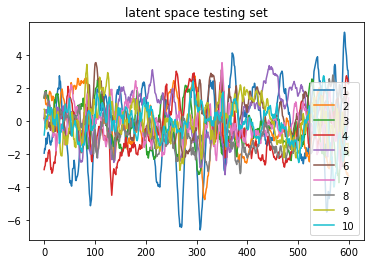

In [4]:
## latent space
print(latent_test.shape)
plt.figure()
for z in range(no_of_modes):
    plt.plot(latent_test[:,z],label=str(z+1))
plt.legend()
plt.title('latent space testing set')
plt.show()

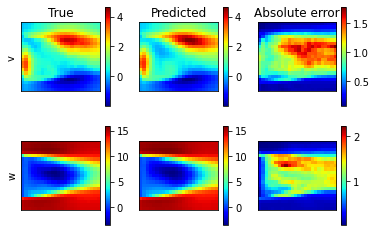

In [17]:
# autoencoder results
which_mode = 2 # start from 0

myplot.plot_ae_results(u_test,y_test[which_mode,:,:,:,:],u_avg,'mae')

In [4]:
## modes
# modes_test = [subnets[0].predict([u_test])]
# for z in range(1,no_of_modes):
#     new_mode = subnets[z].predict(inn[:z+1]) - modes_test[z-1]
#     modes_test.append(new_mode)
# modes_test = np.array(modes_test)
# print(modes_test.shape)

modes_test = np.copy(y_test)
for z in range(1,no_of_modes):
    modes_test[z,:,:,:,:] = modes_test[z,:,:,:,:] - modes_test[z-1,:,:,:,:]
print(modes_test.shape)

(10, 600, 21, 24, 2)


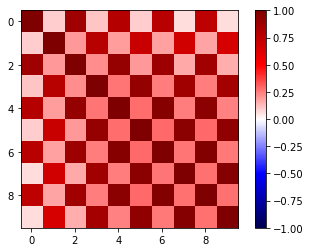

In [7]:
flatmodes = np.reshape(modes_test,[no_of_modes,-1])
cov = np.corrcoef(flatmodes)
# cov = np.corrcoef(latent_test.T)
plt.figure()
plt.imshow(cov,cmap='seismic',vmin=-1,vmax=1)
plt.colorbar()
plt.show()

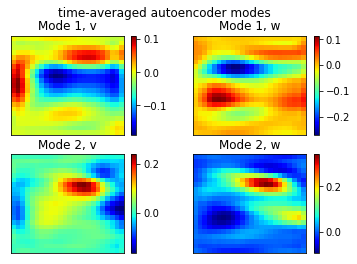

In [5]:
## plot time-averaged autoencoder mode
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

mode1_1 = ax1.imshow(np.mean(modes_test,axis=1)[0,:,:,0],'jet')
ax1.set_title("Mode 1, v")
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(mode1_1,ax=ax1)

mode1_2 = ax2.imshow(np.mean(modes_test,axis=1)[0,:,:,1],'jet')
ax2.set_title("Mode 1, w")
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(mode1_2,ax=ax2)

mode2_1 = ax3.imshow(np.mean(modes_test,axis=1)[1,:,:,0],'jet')
ax3.set_title("Mode 2, v")
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(mode2_1,ax=ax3)

mode2_2 = ax4.imshow(np.mean(modes_test,axis=1)[1,:,:,1],'jet')
ax4.set_title("Mode 2, w")
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(mode2_2,ax=ax4)
plt.suptitle("time-averaged autoencoder modes")

plt.show()

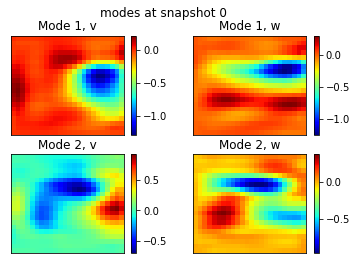

In [6]:
## plt instantaneous modes
time = 0
fig,ax = plt.subplots(2,2)
plt.suptitle('modes at snapshot '+str(time))
    
mode1_v = ax[0,0].imshow(modes_test[0,time,:,:,0],'jet')
ax[0,0].set_title('Mode 1, v')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(mode1_v,ax=ax[0,0])

mode1_w = ax[0,1].imshow(modes_test[0,time,:,:,1],'jet')
ax[0,1].set_title('Mode 1, w')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(mode1_w,ax=ax[0,1])

mode2_v = ax[1,0].imshow(modes_test[1,time,:,:,0],'jet')
ax[1,0].set_title('Mode 2, v')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(mode2_v,ax=ax[1,0])

mode2_w = ax[1,1].imshow(modes_test[1,time,:,:,1],'jet')
ax[1,1].set_title('Mode 2, w')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(mode2_w,ax=ax[1,1])

plt.show()

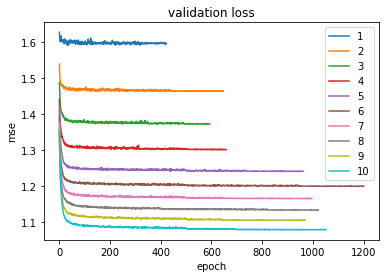

In [10]:
'''training curve'''
idx = np.where(hist_train == -1)[0]
idxval = np.where(hist_val == -1)[0]
plt.figure()
# plt.title('training loss')
plt.title('validation loss')
# plt.plot(hist_train[:idx[0]],label='subnet 1')
plt.plot(hist_val[:idx[0]],label='1')
for i in range(1,no_of_modes):
    label = 'subnet ' + str(i+1)
    # plt.plot(hist_train[idx[i-1]+1:idx[i]],label=label)
    plt.plot(hist_val[idx[i-1]+1:idx[i]],label=str(i+1))
plt.legend()
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()

## mode decomposition

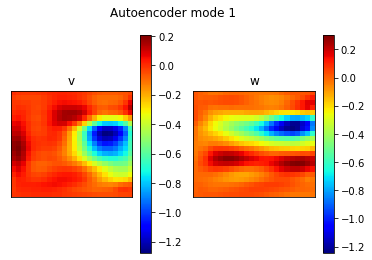

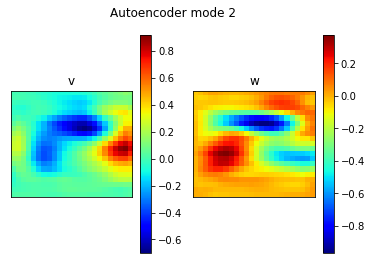

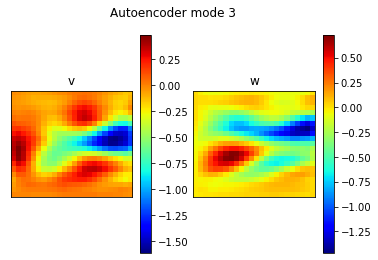

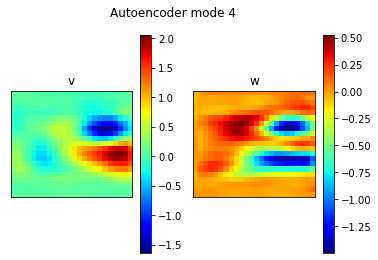

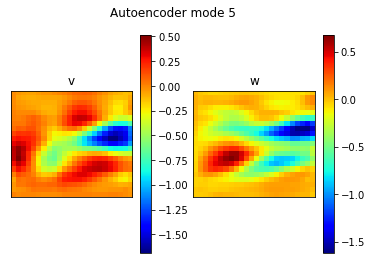

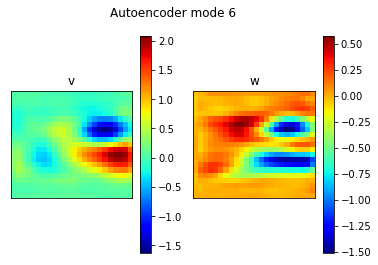

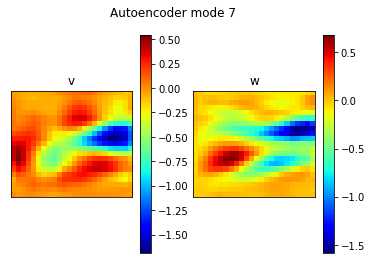

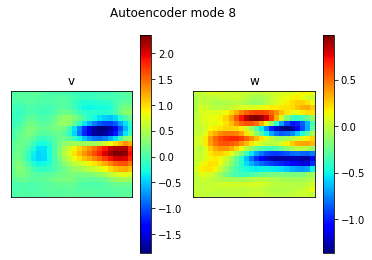

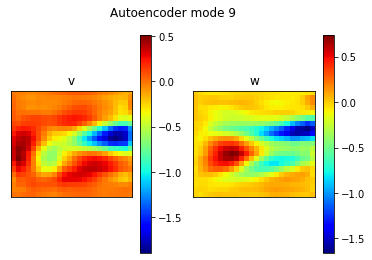

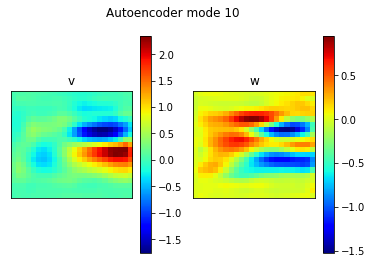

In [7]:
myplot.plot_ae_modes(modes_test,range(10),snapshot=0)

In [22]:
## build matrix
which_decoder = 1
vy = modes_test[which_decoder,:,:,:,0]
vy = np.transpose(vy,[1,2,0])
vz = modes_test[which_decoder,:,:,:,1]
vz = np.transpose(vz,[1,2,0])
X = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
print(X.shape)

(42, 24, 600)


In [23]:
# POD
pod = md.POD(X)
Q_POD,lam = pod.get_modes()
Q_mean = pod.Q_mean

# DMD
dmd = md.DMD(X[:,:,:-1],X[:,:,1:],r=50,keep_shape=True)
Phi,Lambda,b = dmd.get_modes()

# parameters
D       = 196.5;    # Model diameter in mm
Uinf    = 15;       # Nominal free stream velocity
fPIV    = 720;      # PIV sampling frequency
dt      = 1/fPIV;   # Delta t between image pairs

Calculating POD ...
Use snapshot POD, Nx > Nt.
POD done.
Calculating DMD...
DMD done.


/home/ym917/Documents/Codes/MD-CNN-AE/mode_decomposition.py:202: RuntimeWarning: invalid value encountered in sqrt
  Q_POD = (Q@Phi)*(1/(lam**0.5).T)


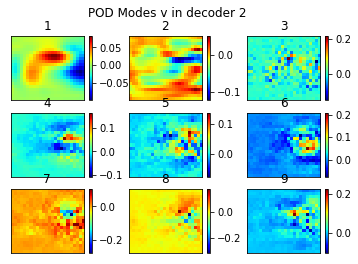

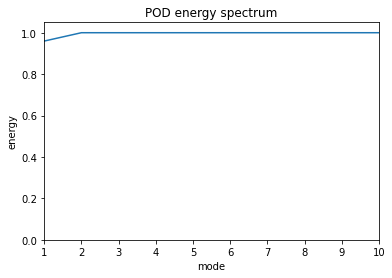

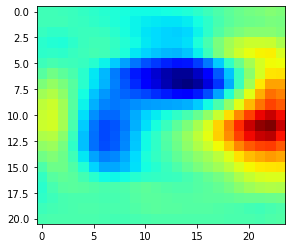

snapshot


In [24]:
## plot POD
PlotWhichVelocity = 'v' 
save_img = False

fig = plt.figure(1)
title = "POD Modes " + PlotWhichVelocity + " in decoder " + str(which_decoder+1)
# title = "POD Modes "+PlotWhichVelocity
plt.suptitle(title)
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*Ny,Nz])
    if PlotWhichVelocity == 'w': # Q was built [vz,vy]
        pltV = pltV[0:Ny,:]
    elif PlotWhichVelocity == 'v':
        pltV = pltV[Ny:,:]
    elif PlotWhichVelocity == 'V':
        pltV = (pltV[0:Ny,:]**2 + pltV[Ny:,:]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()
if save_img:
    p = folder + "POD_modes_" + str(which_decoder+1) + PlotWhichVelocity + ".png"
    plt.savefig(p)
else:
    plt.show()

## Spectrum
energy = np.cumsum(lam/np.sum(lam))
plt.figure()
plt.title('POD energy spectrum')
plt.plot(np.arange(len(energy))+1,energy)
plt.ylabel('energy')
plt.xlabel('mode')
plt.xlim([1,10])
plt.ylim([0,1.05])
if save_img:
    p = folder + "POD_spectrum_" + str(which_decoder+1) + ".png"
    plt.savefig(p)
else:
    plt.show()

## Reconstruct
rebuildv = pod.reconstruct(number_of_modes=2,t=1,shape=[2,Ny,Nz])
if PlotWhichVelocity == 'w': # Q was built [vz,vy]
    rebuildv = rebuildv[0,:,:]
elif PlotWhichVelocity == 'v':
    rebuildv = rebuildv[1,:,:]
plt.figure()
plt.imshow(rebuildv.real,'jet')
plt.show()
print(pod.typePOD)

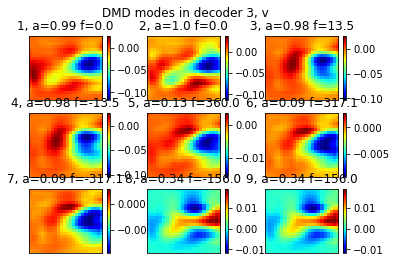

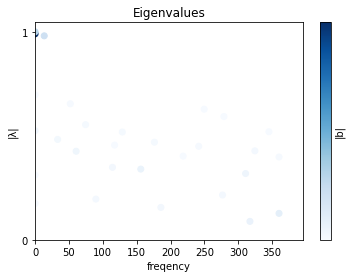

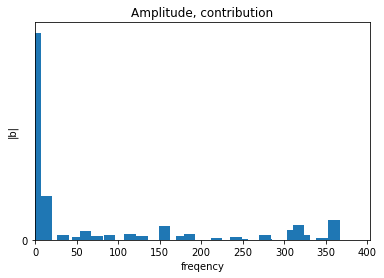

In [44]:
## plot DMD
mode_z = Phi[:Ny,:,:].real # X was built vstack(vz,vy)
mode_y = Phi[Ny:,:,:].real # has shape [ny,nz,modes]

whichmode = 0
whichvelocity = 'v'
save_img = False
# plot mean flow (b = 1.0)
# plt.figure()
# if whichvelocity == 'w':
#     plt.imshow(mode_z[:,:,whichmode],'jet')
# else:
#     plt.imshow(mode_y[:,:,whichmode],'jet')
# # plt.title('decoder '+str(WhichDecoder+1))
# plt.show()
# print(np.diag(Lambda)[whichmode])

plt.suptitle("DMD modes in decoder " + str(which_decoder+1) + ", " + whichvelocity)
# plt.suptitle("DMD modes "+ whichvelocity)
lam = np.diag(Lambda)
lam_r = np.abs(lam)
lam_f = np.angle(lam)/(2*np.pi)/dt
for i in range(9):
    title = str(i+1)+', a='+str(np.around(lam_r[i],decimals=2))+" f="+str(np.around(lam_f[i],1))
    ax = plt.subplot(3,3,i+1,title=title,xticks=[],yticks=[])
    if whichvelocity == 'w': # Q was built [vz,vy]
        pltV = mode_z[:,:,i]
    elif whichvelocity == 'v':
        pltV = mode_y[:,:,i]
    elif whichvelocity == 'V':
        pltV = (mode_z[:,:,i]**2 + mode_y[:,:,i]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()
if save_img:
    p = folder + "DMD_modes_" + str(which_decoder+1) + whichvelocity + ".png"
    plt.savefig(p)
else:
    plt.show()


## eigenvalue plot, temporal behaviour
lam_r, lam_f = dmd.get_frequency(dt)
b_r = dmd.get_amplitude()
plt.figure()
plt.scatter(lam_f,lam_r,c=b_r,cmap='Blues',vmin=0,vmax=max(b_r))
plt.colorbar(label='|b|',ticks=[])
plt.xlabel('freqency')
plt.ylabel('|λ|')
plt.title('Eigenvalues')
plt.yticks([0,1])
# plt.hlines(1,0,360,colors='k',linestyles='dotted')
plt.xlim(left=0)
plt.show()

# ## plot amplitude
max_fq = max(lam_f)
plt.figure()
# plt.plot(lam_f_sorted,b_r_sorted)
plt.bar(lam_f,b_r,width=700/dmd.r)
plt.xlabel('freqency')
plt.ylabel('|b|')
plt.title('Amplitude, contribution')
# plt.xticks([])
plt.xlim(left=0)
plt.yticks([0])
if save_img:
    p = folder + "DMD_amp_" + str(which_decoder+1) + ".png"
    plt.savefig(p)
else:
    plt.show()